<a href="https://colab.research.google.com/github/lagom-QB/M11/blob/master/Practice_4_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Troubleshooting. Hyperparameter Choice.

# keywords: learning rate, vanishing and exploding gradients, scheduler

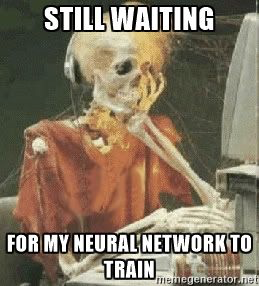

Training a neural network can be time consuming (and expensive) process. 
And if we want to build an effective solution we may have to train it hundred of times changing model/training parameters.

What parameters (roughly in importance order) to alter?
1. Learning rate.
2. Architecture choice.
3. Dataset preprocessing.
4. Architecture parameters.
5. Optimizer.
6. Training time.
7. Batch size.
8. Optimizer parameters.

We will discuss (2,3,4) later.

# Learning rate (and a bit of batch size).

Rule of thumb: find the largest lr, when the model ist still training. Divide by 2.

In [0]:
import torch

In [0]:
from torchvision import datasets, transforms
train_dataset = datasets.MNIST('/data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))
test_dataset = datasets.MNIST('../data', train=False, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4096, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4096, shuffle=True)

Note: we increased the batch_size to speed up experiments a bit.

In [0]:
import torch.nn as nn
from torch.nn.modules import loss

class Flatten(nn.Module):
  def forward(self, x):
    batch_size = x.shape[0]
    return x.view(batch_size, -1)

def get_model():
  return nn.Sequential(Flatten(), 
                       nn.Linear(784, 512), 
                       nn.Tanh(),
                       nn.Linear(512, 64), 
                       nn.Tanh(),
                       nn.Linear(64, 10))

loss_function = loss.CrossEntropyLoss()

def train(model, train_loader, optimizer, loss_function, epoch, writer):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_loss /= len(train_loader.dataset)
    writer.add_scalar("train_loss", train_loss, global_step=epoch)

def test(model, test_loader, loss_function, epoch, writer):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += loss_function(output, target).sum().item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    writer.add_scalar("test_loss", test_loss, global_step=epoch)
    writer.add_scalar("accuracy", accuracy, global_step=epoch)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [0]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

In [0]:
!rm -r logs1

In [0]:
!kill 1120

In [0]:
%tensorboard --logdir logs1

In [0]:
def train_with_lr(lr, model, epochs=5, start_epoch=0):
  writer = SummaryWriter(log_dir=f"logs1/lr{lr}")
  optim = torch.optim.SGD(model.parameters(), lr=lr)
  for epoch in range(start_epoch, start_epoch + epochs):
    train(model, train_loader, optim, loss_function, epoch, writer)
    test(model, test_loader, loss_function, epoch, writer)
  writer.close()

In [0]:
model = get_model()
%time train_with_lr(2, model)

In [0]:
 model = get_model()
%time train_with_lr(1, model)

lr = 0.5 should be ok.

In [0]:
model = get_model()
%time train_with_lr(0.5, model, epochs=20)

What happens if we return to 64 batch size?
It depends on implementation of the loss function.

In [0]:
def cross_entropy(input, target, weight=None, size_average=None, ignore_index=-100,
                  reduce=None, reduction='mean'):
    # type: (Tensor, Tensor, Optional[Tensor], Optional[bool], int, Optional[bool], str) -> Tensor
    r"""This criterion combines `log_softmax` and `nll_loss` in a single
    function.
    See :class:`~torch.nn.CrossEntropyLoss` for details.
    Args:
        input (Tensor) : :math:`(N, C)` where `C = number of classes` or :math:`(N, C, H, W)`
            in case of 2D Loss, or :math:`(N, C, d_1, d_2, ..., d_K)` where :math:`K \geq 1`
            in the case of K-dimensional loss.
        target (Tensor) : :math:`(N)` where each value is :math:`0 \leq \text{targets}[i] \leq C-1`,
            or :math:`(N, d_1, d_2, ..., d_K)` where :math:`K \geq 1` for
            K-dimensional loss.
        weight (Tensor, optional): a manual rescaling weight given to each
            class. If given, has to be a Tensor of size `C`
        size_average (bool, optional): Deprecated (see :attr:`reduction`). By default,
            the losses are averaged over each loss element in the batch. Note that for
            some losses, there multiple elements per sample. If the field :attr:`size_average`
            is set to ``False``, the losses are instead summed for each minibatch. Ignored
            when reduce is ``False``. Default: ``True``
        ignore_index (int, optional): Specifies a target value that is ignored
            and does not contribute to the input gradient. When :attr:`size_average` is
            ``True``, the loss is averaged over non-ignored targets. Default: -100
        reduce (bool, optional): Deprecated (see :attr:`reduction`). By default, the
            losses are averaged or summed over observations for each minibatch depending
            on :attr:`size_average`. When :attr:`reduce` is ``False``, returns a loss per
            batch element instead and ignores :attr:`size_average`. Default: ``True``
        reduction (string, optional): Specifies the reduction to apply to the output:
            ``'none'`` | ``'mean'`` | ``'sum'``. ``'none'``: no reduction will be applied,
            ``'mean'``: the sum of the output will be divided by the number of
            elements in the output, ``'sum'``: the output will be summed. Note: :attr:`size_average`
            and :attr:`reduce` are in the process of being deprecated, and in the meantime,
            specifying either of those two args will override :attr:`reduction`. Default: ``'mean'``
    Examples::
        >>> input = torch.randn(3, 5, requires_grad=True)
        >>> target = torch.randint(5, (3,), dtype=torch.int64)
        >>> loss = F.cross_entropy(input, target)
        >>> loss.backward()
    """
    if not torch.jit.is_scripting():
        tens_ops = (input, target)
        if any([type(t) is not Tensor for t in tens_ops]) and has_torch_function(tens_ops):
            return handle_torch_function(
                cross_entropy, tens_ops, input, target, weight=weight,
                size_average=size_average, ignore_index=ignore_index, reduce=reduce,
                reduction=reduction)
    if size_average is not None or reduce is not None:
        reduction = _Reduction.legacy_get_string(size_average, reduce)
    return nll_loss(log_softmax(input, 1), target, weight, None, ignore_index, None, reduction)

In [0]:
model = get_model()
%time train_with_lr(0.05, model, epochs=5, start_epoch=20)

In [0]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

In [0]:
def train_small_batch_with_lr(lr, model, epochs=5, start_epoch=0):
  writer = SummaryWriter(log_dir=f"logs1/lr{lr}_batch16")
  optim = torch.optim.SGD(model.parameters(), lr=lr)
  for epoch in range(start_epoch, start_epoch + epochs):
    train(model, train_loader, optim, loss_function, epoch, writer)
    test(model, test_loader, loss_function, epoch, writer)
  writer.close()

In [0]:
 model = get_model()
%time train_small_batch_with_lr(1, model)

In [0]:
 model = get_model()
%time train_small_batch_with_lr(0.1, model)

# Scheduler

Sometimes it may be reasonable to alter learning rate during training. 

In [0]:
def train_with_scheduler(model, scheduler, optimizer, epochs=5, start_epoch=0):
  writer = SummaryWriter(log_dir=f"logs1/scheduler")
  for epoch in range(start_epoch, start_epoch + epochs):
    train(model, train_loader, optim, loss_function, epoch, writer)
    test(model, test_loader, loss_function, epoch, writer)
    scheduler.step()
  writer.close()

In [0]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4096, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4096, shuffle=True)

In [0]:
model = get_model()
optim = torch.optim.SGD(model.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 10, gamma=0.1, last_epoch=-1)
train_with_scheduler(model, scheduler, optim, epochs=20)

Another way to find good lr (Leslie N. Smith [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186)): 

In [0]:
def lr_finder(model, train_loader, optimizer, loss_function):
    writer = SummaryWriter(log_dir=f"logs1/lr_finder")
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 1.2, last_epoch=-1)
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        writer.add_scalar("batch_loss", loss, global_step=batch_idx)
        writer.add_scalar("lr", torch.tensor(scheduler.get_last_lr()), global_step=batch_idx)
    writer.close()


In [0]:
model = get_model()

In [0]:
lr_finder(model, train_loader, torch.optim.SGD(model.parameters(), lr=0.1), loss_function)

# Optimizer

For most of CV tasks (classification/detection/segmentation):



Adam is one of the best optimizers to try first (with default parameters). Usually it's not the best, but default parameters works reasonably well in most real-world scenarios. You may still need to tune lr/introduce a scheduler (do not use Smith's method for Adam), but due to its adaptive nature the range of "proper" lrs is usually pretty large. It's prone to overfitting, so additional attention to regularization may be needed.

In [0]:
optim = torch.optim.Adam(params)


SGD with properly tuned hyperparameters usually beats Adam (it may be worse on the train set, but generalizes better). It may be pretty slow, so usually step_scheduler is benefitial.

# Training time

Can be tuned "for free" using early stoping technique.

In [0]:
def train_with_lr_checkpoints(lr, model, checkpoint_dir, epochs=5, start_epoch=0):
  writer = SummaryWriter(log_dir=f"logs1/lr{lr}_checkpoints")
  optim = torch.optim.SGD(model.parameters(), lr=lr)
  for epoch in range(start_epoch, start_epoch + epochs):
    train(model, train_loader, optim, loss_function, epoch, writer)
    torch.save(model.state_dict(), f"{checkpoint_dir}/epoch_{epoch}.pth")
    test(model, test_loader, loss_function, epoch, writer)
  writer.close()

In [0]:
model = get_model()

In [0]:
!mkdir checkpoints

In [0]:
train_with_lr_checkpoints(0.5, model, "checkpoints")

In [0]:
model.load_state_dict(torch.load("checkpoints/epoch_2.pth"))

Most optimizers have some state too (i.e. momentum_buffer). If you are going to continue training your model after serialization, it's better to save their state (and epoch number for scheduler) too.

In [0]:
def train_with_lr_checkpoints_better(lr, model, optim, checkpoint_dir, epochs=5, start_epoch=0):
  writer = SummaryWriter(log_dir=f"logs1/lr{lr}_checkpoints_better")
  for epoch in range(start_epoch, start_epoch + epochs):
    train(model, train_loader, optim, loss_function, epoch, writer)
    state = {"model_state": model.state_dict(),
             "optimizer_state": optim.state_dict(),
             "epoch": epoch}
    torch.save(state, f"{checkpoint_dir}/epoch_{epoch}.pth")
    test(model, test_loader, loss_function, epoch, writer)
  writer.close()

In [0]:
model = get_model()
optim = torch.optim.SGD(model.parameters(), lr=0.5)

In [0]:
train_with_lr_checkpoints_better(0.5, model, optim, "checkpoints")

In [0]:
state = torch.load("checkpoints/epoch_2.pth")

In [0]:
state

In [0]:
model.load_state_dict(state["model_state"])

In [0]:
optim.load_state_dict(state["optimizer_state"])

# Batch size

Large batch size (with proper lr) usually trains faster (especially on GPU).

Large batch size usually is easier to train (wider range of hyperparameters/models works).

Large batch size requires more RAM.

Large batch size is prone to overfitting.

Usually "best" value is `32` - `1024`. It's better to use `2**x` for more effective memmory usage.

# Optimizer parameters

Four methods:
1. Do not touch.
2. Grid search.
3. Random search.
4. ML/bayesian approaches. 

# Troubleshooting

## One-batch overfitting

In [0]:
first_batch = torch.utils.data.Subset(train_dataset, range(0, 64))

In [0]:
train_loader = torch.utils.data.DataLoader(first_batch, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(first_batch, batch_size=64, shuffle=True)

In [0]:
model = get_model()

In [0]:
train_with_lr(0.1, model, epochs=20)

# Model inspection

If model can not overfit:
1. Check parameters. Get any subset of parameters (ex. [0:10] of the first linear layer). Check that they are changing.
2. Check gradients. For each parameter group print maximum absolute value of gradients. 

 a) If they are too large and growing uncontrollably, you can "clip" them. Choose a threshold m, and replace all gradients > m, by threshold value.
 
 b) If they are too small (usually for "starting" layers) you can tune lr for the specific layer, or change model architecture.

# Assignment

1. Find the best learning rate for our model for SGD optimizer and batch_size=64. Use both methods we discussed in the class [2].
2. How large is the maximal absolute value of the gradient in the model after the first training batch? Set threshold to half the value of the largest gradient and clip gradients with this threshold. How does it affect the training? [3]
3. Modify model/loss function in such a way, that it's still trainable with Adam optimizer, but it is not trainable with Adam optimizer with default parameters/learning rate. [3]
4. We found that if we initialize all model weights with `0` it is not training. Find out, what exactly went wrong (you may want to print some subsets of gradients of the model).[2]